In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from shutil import copyfile
import shutil
import random
from tensorflow.keras.callbacks import ModelCheckpoint
random.seed(0)

In [2]:
print(os.listdir('new'))

['mask', 'nomask']


In [3]:
shutil.rmtree('/datam')
os.makedirs('/datam/Maskdata/')
os.makedirs('/datam/Maskdata/training/')
os.makedirs('/datam/Maskdata/testing/')
os.makedirs('/datam/Maskdata/training/mask/')
os.makedirs('/datam/Maskdata/training/no_mask/')
os.makedirs('/datam/Maskdata/testing/mask/')
os.makedirs('/datam/Maskdata/testing/no_mask/')

In [4]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset=[]
    for i in os.listdir(SOURCE):
        if os.path.getsize(SOURCE+i)>0:
            dataset.append(i)
        else:
            
            print('skipped')
    train_set_size=int(len(dataset)*SPLIT_SIZE)
    test_set_size=int(len(dataset)-train_set_size)
    s=random.sample(dataset,len(dataset))
    train=s[0:train_set_size]
    test=s[:test_set_size]
    for i in train:
        y=SOURCE+i
        d=TRAINING+i
        copyfile(y,d)
    for i in test:
        y=SOURCE+i
        d=TESTING+i
        copyfile(y,d)


In [5]:
mask_source='new/mask/'
train_mask='/datam/Maskdata/training/mask/'
test_mask='/datam/Maskdata/testing/mask/'
no_mask_source='new/nomask/'
train_no_mask='/datam/Maskdata/training/no_mask/'
test_no_mask='/datam/Maskdata/testing/no_mask/'
sp=0.91
split_data(mask_source,train_mask,test_mask,sp)
split_data(no_mask_source,train_no_mask,test_no_mask,sp)

In [6]:
train_mask_dir='/datam/Maskdata/training/mask/'
train_no_mask_dir='/datam/Maskdata/training/no_mask/'
valid_mask_dir='/datam/Maskdata/testing/mask/'
valid_no_mask_dir='/datam/Maskdata/testing/no_mask/'
print(len(os.listdir(train_mask_dir)))
print(len(os.listdir(train_no_mask_dir)))
print(len(os.listdir(valid_mask_dir)))
print(len(os.listdir(valid_no_mask_dir)))

627
624
63
62


In [7]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    #tf.keras.layers.Conv2D(400, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 73984)             0

In [8]:
train_dir='/datam/Maskdata/training/'
valid_dir='/datam/Maskdata/testing/'
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
valid_datagen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_data=train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=32,
                                    class_mode='binary',
                                    target_size=(150,150))
valid_data=valid_datagen.flow_from_directory(
                    valid_dir,
                    batch_size=32,
                                    class_mode='binary',
                                    target_size=(150,150))


Found 1251 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [9]:
checkpoint=ModelCheckpoint(
    'model-{epoch:03d}.h5', monitor='val_loss', verbose=0, save_best_only=True,mode='auto')
history = model.fit_generator(
      train_data,
      steps_per_epoch=len(train_data)/20,  
      epochs=107,
      verbose=1,
    callbacks=[checkpoint],
      validation_data = valid_data,
      validation_steps=len(valid_data)/20)

Epoch 1/107


KeyboardInterrupt: 

In [9]:
history = model.fit_generator(
      train_data,
      steps_per_epoch=len(train_data)/10,  
      epochs=80,
      verbose=1,
      validation_data = valid_data,
      validation_steps=len(valid_data)/10)

Epoch 1/80
4/4 [==============================] - 9s 2s/step - loss: 2.1166 - acc: 0.5469 - val_loss: 2.1036 - val_acc: 0.4062
Epoch 2/80
4/4 [==============================] - 3s 733ms/step - loss: 0.7146 - acc: 0.5000 - val_loss: 1.7289 - val_acc: 0.5938
Epoch 3/80
4/4 [==============================] - 3s 733ms/step - loss: 0.7072 - acc: 0.4609 - val_loss: 1.7336 - val_acc: 0.4688
Epoch 4/80
4/4 [==============================] - 4s 933ms/step - loss: 0.6950 - acc: 0.4545 - val_loss: 1.7248 - val_acc: 0.5938
Epoch 5/80
4/4 [==============================] - 3s 725ms/step - loss: 0.6916 - acc: 0.5391 - val_loss: 1.7195 - val_acc: 0.5938
Epoch 6/80
4/4 [==============================] - 3s 729ms/step - loss: 0.6923 - acc: 0.4766 - val_loss: 1.7267 - val_acc: 0.6250
Epoch 7/80
4/4 [==============================] - 3s 730ms/step - loss: 0.6873 - acc: 0.6016 - val_loss: 1.8176 - val_acc: 0.4062
Epoch 8/80
4/4 [==============================] - 3s 725ms/step - loss: 0.7038 - acc: 0.4453 

4/4 [==============================] - 2s 613ms/step - loss: 0.1059 - acc: 0.9495 - val_loss: 1.3219 - val_acc: 0.8125
Epoch 64/80
4/4 [==============================] - 3s 736ms/step - loss: 0.2786 - acc: 0.8750 - val_loss: 0.2657 - val_acc: 0.9688
Epoch 65/80
4/4 [==============================] - 3s 754ms/step - loss: 0.1867 - acc: 0.9375 - val_loss: 0.5010 - val_acc: 0.9375
Epoch 66/80
4/4 [==============================] - 3s 782ms/step - loss: 0.1181 - acc: 0.9688 - val_loss: 0.3331 - val_acc: 0.9375
Epoch 67/80
4/4 [==============================] - 3s 749ms/step - loss: 0.1879 - acc: 0.9141 - val_loss: 0.3638 - val_acc: 0.9062
Epoch 68/80
4/4 [==============================] - 3s 758ms/step - loss: 0.1188 - acc: 0.9453 - val_loss: 0.1016 - val_acc: 0.9688
Epoch 69/80
4/4 [==============================] - 3s 738ms/step - loss: 0.1434 - acc: 0.9453 - val_loss: 0.1130 - val_acc: 1.0000
Epoch 70/80
4/4 [==============================] - 3s 773ms/step - loss: 0.1235 - acc: 0.9531 -

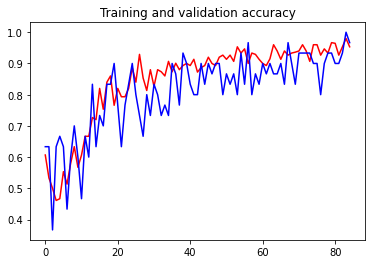

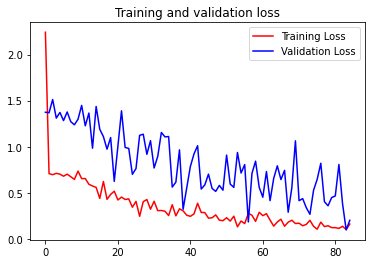

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model.save('mask9662.h5')

In [ ]:
pred=model.predict([per(name)])
print(str(categories[int(pred[0][0])]))

In [ ]:
imarry=cv2.imread(name)

In [ ]:
imarry